# はじめに

機械学習モデルの学習に慣れるために、今回は[pytorchのtutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) を元にやっていこうと思います。

tutorial と同じく、"CIFAR-10" と呼ばれる画像のデータセットを使います。

ゴールは、**画像データの分類モデルの作成・評価**です。



とはいえ、tutorial と同様にライブラリから持ってくるというのは特殊な例です。
- 一般的なデータでも通用するよう、きちんと手作業で取っていきます。

## 持ち帰って欲しいこと

機械学習の流れをなんとなく理解してください。


# 準備

## Utils

必要なライブラリをインストールします。
- pandas, numpy など。

In [ ]:
%matplotlib inline

In [ ]:
!pip install transformers
!pip install timm

In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
import random
import os

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from transformers import get_cosine_schedule_with_warmup
import timm

## CONFIG

機械学習に必要な初期設定をします。

In [ ]:
def CosineAnnealingLR_config():
  return {
    "T_max": 20,
    "min_lr": 1e-5,
  }
def get_cosine_schedule_with_warmup_config():
  return {
      "NUM_WARMUP_STEPS": 10,
      # "NUM_TRAINING_STEPS"
  }

In [ ]:
CONFIG = {
    "DEVICE": 'cuda' if torch.cuda.is_available() else 'cpu',
    "EPOCH": 5,
    "BATCH_SIZE": 4,
    "LERANING_RATE": 1e-3, #1e-5, #1e-3,
    "SCHEDULER": "COSINE_SCHEDULE_WITH_WARMUP", #get_cosine_schedule_with_warmup_config(), #"get_cosine_schedule_with_warmup", #"CosineAnnealingLR", # ExponentialLR
    "SCHEDULER_CONFIG": get_cosine_schedule_with_warmup_config(),
    # "T_0": ,
    "SEED": 2022,
    'NUM_LABEL': 10,
}



In [ ]:
def seed_everything(seed):
  random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True

In [ ]:
seed_everything(CONFIG["SEED"])

## 公式サイトでデータ詳細を見る

[CIFAR-10の公式サイト](https://www.cs.toronto.edu/~kriz/cifar.html)を少しだけ眺めてみましょう。

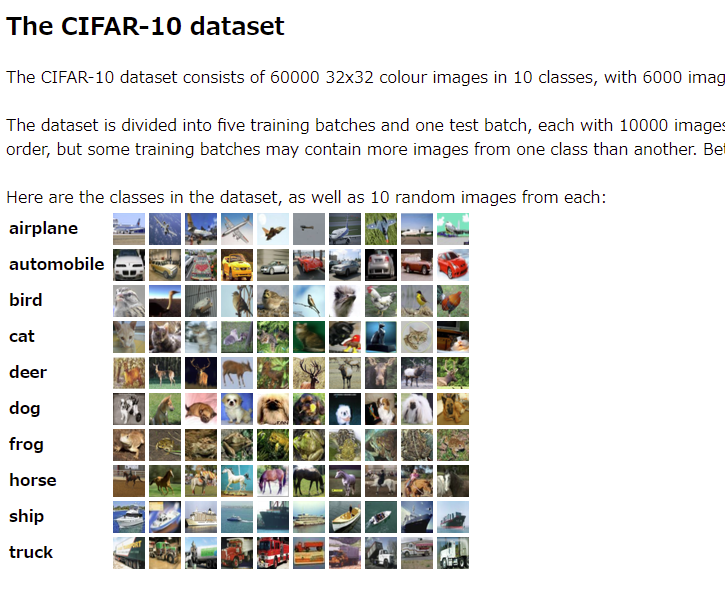

データとしては
- 飛行機
- 自動車
- etc.

サイトから得られる情報
- $32 \times 32$ からなる$60,000$ 個のカラー付き画像データ
 - $1$ クラスに付き$6,000$ 個
- $10$ クラスの分類（飛行機・自動車など）

## データの読み込み

まずはデータ。

以下コマンドで、公式サイトからデータをダウンロード

（補足）google colaboratory では! を先頭に付けるとシェルコマンド
- シェルコマンド1 行だけなら! は省略可能
- 例：`ls`, `pwd`

In [ ]:
if not os.path.exists('/content/cifar-10-python.tar.gz'):
    # CIFAR-10の公式サイトからpython versionをダウンロード（https://www.cs.toronto.edu/~kriz/cifar.html）
    !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

    # tarを解凍
    !tar -zxvf /content/cifar-10-python.tar.gz

図のように、解凍したcifar-10-batches-pyディレクトリとその中身があればOKです。
- 赤枠を押してワークスペースのディレクトリ情報を更新してください。

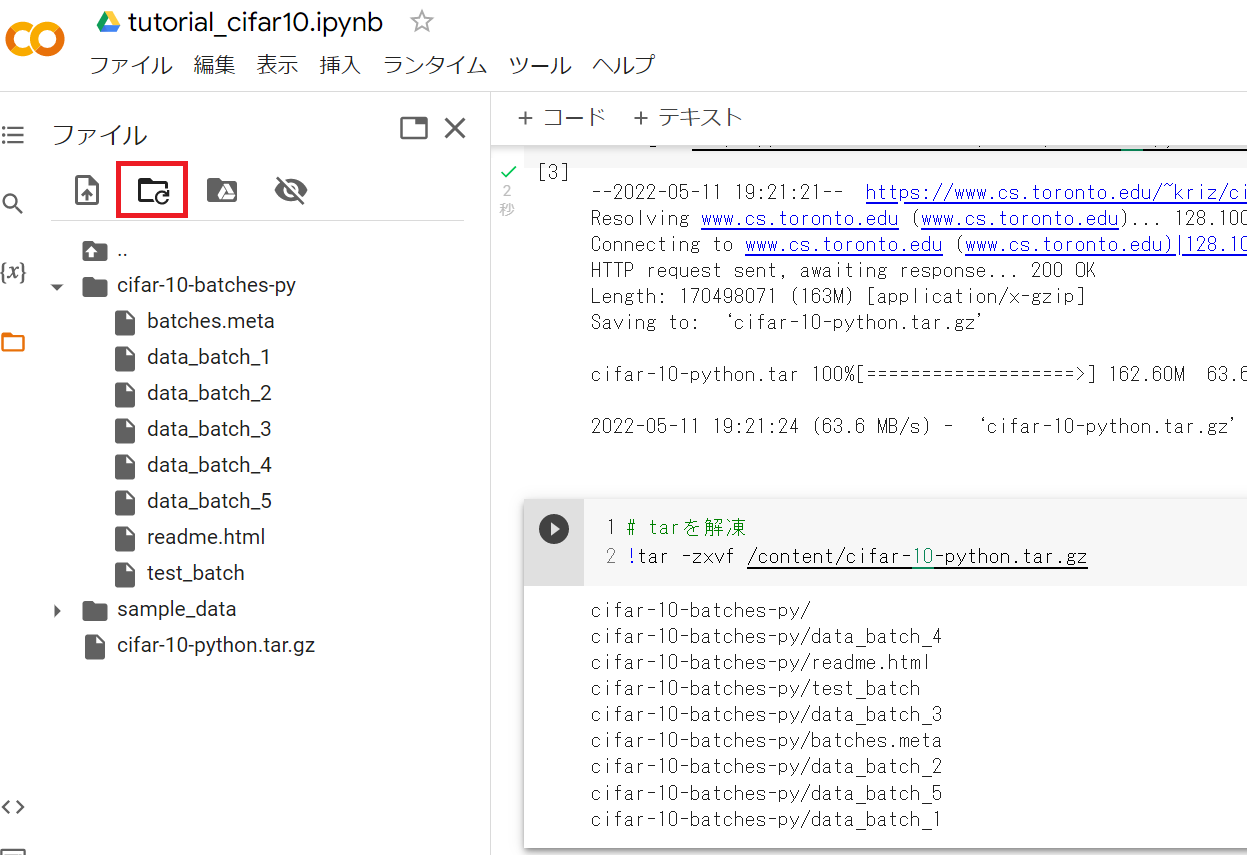

`data_batch_*` とは？

公式の[Dataset layout](https://www.cs.toronto.edu/~kriz/cifar.html#:~:text=here%20to%20view.-,Dataset%20layout,-Python%20/%20Matlab%20versions)の箇所を読む
- すでにいくつかのバッチに分けてくれている

pickleで解凍しろと書いてあるので解凍します。

In [ ]:
cifer10_dir = '/content/cifar-10-batches-py'

meta_data = pd.read_pickle(f'{cifer10_dir}/batches.meta')

cifer10_batches = []
for i in range(1, 6):
    i_batch = pd.read_pickle(f'{cifer10_dir}/data_batch_{i}')

    cifer10_batches.append(i_batch)


ファイルの準備が整いました。

# EDA （探索的データ分析）

中身を見る

### meta_data

In [ ]:
meta_data

{'num_cases_per_batch': 10000,
 'label_names': ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 'num_vis': 3072}

変数名の通り、メタデータ

label_namesがラベルのようなので、数を確認

In [ ]:
len(meta_data["label_names"])

10

ラベルの数が10個なので、先ほどのパっと見と合っています

In [ ]:
label_names = meta_data['label_names']

ラベルの名前だけ取り出しておきます。
- 他の変数は使わなそうなので、今回は無視します。

### data

前の手順で、5個に分かれているバッチをcifer10_batchesとしてまとめました。

最初のバッチを見てみます。

In [ ]:
cifer10_batches[0].keys()

dict_keys(['batch_label', 'labels', 'data', 'filenames'])

各々のbatchはdict型でデータが入っているようです。

batch0のdictの中身を見てみましょう。

In [ ]:
for k,v in cifer10_batches[0].items():
    print(k)
    if k=='batch_label':
        print(v)
    else:
        print(v[:10])

    # 改行
    print()

batch_label
training batch 1 of 5

labels
[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]

data
[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 28  30  33 ... 100  99  96]
 [134 131 128 ... 136 137 138]
 [125 110 102 ...  82  84  86]]

filenames
['leptodactylus_pentadactylus_s_000004.png', 'camion_s_000148.png', 'tipper_truck_s_001250.png', 'american_elk_s_001521.png', 'station_wagon_s_000293.png', 'coupe_s_001735.png', 'cassowary_s_001300.png', 'cow_pony_s_001168.png', 'sea_boat_s_001584.png', 'tabby_s_001355.png']



#### batch_label

何個めのバッチか書いてあるだけ。

#### labels

ラベルがint型で入ってるようです。
全てのバッチの中身を結合して、10種類か確認します。

In [ ]:
labels = []
for i in range(5):
  i_labels = cifer10_batches[i]['labels']
  labels += i_labels

labels[:10]

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]

In [ ]:
len(labels)

50000

全てのラベルの個数は計50,000のようです。

パっと見で全てのデータ数が60,000だったので、
残りの10,000はtest_batchであることが想像できます。

ユニークを取ります。

In [ ]:
uni_labels = np.unique(labels)
uni_labels

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
n_labels = len(uni_labels)
n_labels

10

想定と合っていそうです。

#### data

まずは全てのバッチのデータの次元数を見てみます。

In [ ]:
for i in range(5):
  i_data = cifer10_batches[i]['data']
  print('type:', type(i_data))
  print('shape:', i_data.shape)

type: <class 'numpy.ndarray'>
shape: (10000, 3072)
type: <class 'numpy.ndarray'>
shape: (10000, 3072)
type: <class 'numpy.ndarray'>
shape: (10000, 3072)
type: <class 'numpy.ndarray'>
shape: (10000, 3072)
type: <class 'numpy.ndarray'>
shape: (10000, 3072)


各バッチのデータは$10000 \times 3072$ のnumpy 型で出来ていることが確認できます。

パっと見で、データの画像のサイズは$32 \times 32$のカラー付き画像データでした。ここで、

\begin{equation}3072/(32 \times 32) = 3072/1024=3\end{equation}

ですので、$3072$というのは

\begin{equation}
\text{data}(3072) = \text{width}(32) \times \text{height}(32) \times \text{channel}(3)
\end{equation}

と考えられます（channelはRGBでしょうか。）。

なにはともあれ、画像として可視化すれば分かることなので、可視化してみましょう。

参考：https://www.kaggle.com/code/awsaf49/uwmgi-unet-train-pytorch#%F0%9F%8C%88-Augmentations

可視化するにあたって、色々準備をします。

## Transforms

データを変形する関数として、transforms を定義します。
- 現段階では、$1$ 次元であるデータを$3$ 次元に変換しています。

In [ ]:
def transforms(image):
  # モデルへの入力に変形する： [channel * height * width]-> [channel, height, width]
  image = image.reshape([3, 32, 32]).transpose(0,2,1)

  return image

## Dataset

pytorch では、`DataLoader` と`Dataset` を組み合わせて以下の流れで使うのが主流です。
1. `Dataset` で１つずつ取り出す、`__getitem__`を定義
1. `DataLoader` で`Dataset` を受け取り、バッチサイズでまとめて取り出す



こういうものだと考えて使ってしまっていいと思います。
- 本当はマルチプロセスに対応したり、`sampler` 定義などもっと高速化できますが今回はシングルプロセスでやります。
- 参考：https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587, https://qiita.com/tomp/items/3bf6d040bbc89a171880

In [ ]:
class Cifar10Dataset(Dataset):
    def __init__(self, images, labels, is_train=True, transforms=None):
        self.images = images
        self.labels = labels
        self.is_train = is_train
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]

        if self.is_train:
            label = self.labels[index]
            if self.transforms:
                image = self.transforms(image=image)
            return torch.tensor(image, dtype=torch.float32).to(CONFIG["DEVICE"]), \
            torch.tensor(label, dtype=torch.long).to(CONFIG['DEVICE'])
        else:
            if self.transforms:
                image = self.transforms(image=image)
            # img = np.transpose(img, (2, 0, 1))
            return torch.tensor(image, dtype=torch.float32).to(CONFIG["DEVICE"])

In [ ]:
debug_target = cifer10_batches[0]
debug_dataset = Cifar10Dataset(images=debug_target['data'],
                               labels=debug_target['labels'], is_train=True,
                               transforms=transforms)

In [ ]:
debug_loader = DataLoader(debug_dataset, batch_size=CONFIG["BATCH_SIZE"],
                        #   num_workers=1,
                          shuffle=True,
                        #   pin_memory=True,
                          drop_last=False,
                        #   worker_init_fn=lambda x: seed_everything(CONFIG["SEED"])
                        )

`DataLoader` をイテレータとして見ることで、`Dataset` からバッチサイズの数だけ`data` を取り出せます。
- ここでは`is_train=True` として`debug_dataset` を定義したので、(`image`, `label`)がそれぞれバッチサイズの個数返ってきます。
 - `DataLoader` は`Dataset` を結合して返すイメージです。（本当は`Sampler` に依ると思います）

In [ ]:
image, label = next(iter(debug_loader))

In [ ]:
image

tensor([[[[198., 201., 205.,  ..., 208., 219., 217.],
          [201., 204., 208.,  ..., 187., 207., 220.],
          [194., 200., 207.,  ..., 167., 191., 220.],
          ...,
          [193., 192., 203.,  ..., 213., 218., 218.],
          [176., 195., 204.,  ..., 213., 213., 215.],
          [174., 198., 205.,  ..., 211., 208., 212.]],

         [[206., 205., 205.,  ..., 204., 211., 213.],
          [209., 209., 208.,  ..., 196., 212., 217.],
          [202., 204., 207.,  ..., 186., 206., 219.],
          ...,
          [190., 191., 203.,  ..., 207., 213., 215.],
          [174., 193., 204.,  ..., 209., 209., 212.],
          [172., 196., 204.,  ..., 210., 206., 209.]],

         [[156., 158., 159.,  ..., 174., 176., 173.],
          [159., 161., 162.,  ..., 174., 184., 177.],
          [153., 157., 161.,  ..., 170., 183., 180.],
          ...,
          [154., 149., 153.,  ..., 171., 176., 174.],
          [138., 151., 155.,  ..., 172., 171., 172.],
          [136., 154., 155.,  ...

In [ ]:
image.shape

torch.Size([4, 3, 32, 32])

$\text{バッチサイズ}(4) \times \text{channel}(3) \times \text{height}(32) \times \text{width}(32)$ がきちんと返ってきていることが確認できます。

In [ ]:
label

tensor([4, 5, 6, 1], device='cuda:0')

In [ ]:
label.shape

torch.Size([4])

バッチサイズの個数だけlabelも返ってきているので問題無さそうです。

## 可視化

deer


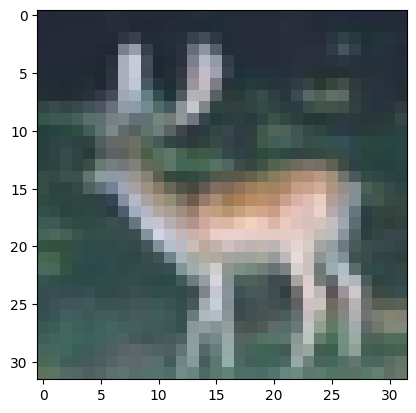

frog


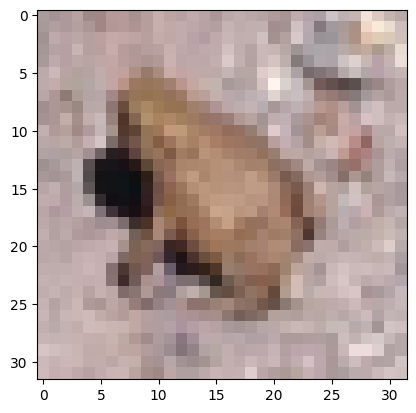

ship


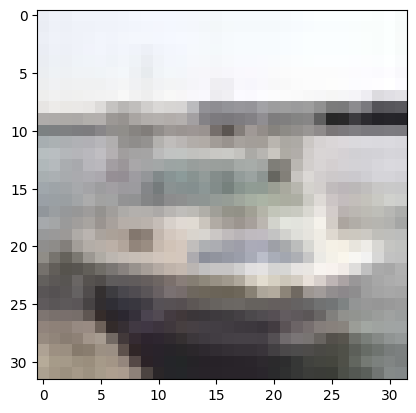

automobile


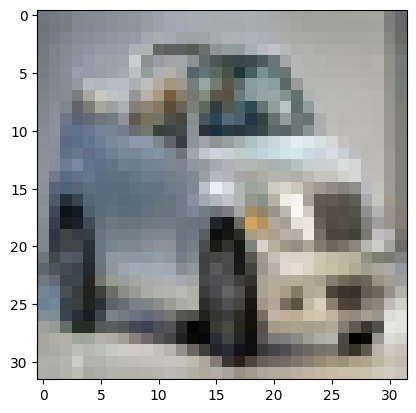

In [ ]:
def imshow(img):
    img = img.transpose(0,2) # -> [width, height, channel]
    plt.imshow(img.detach().cpu().to(torch.long))
    plt.show()

images, labels = next(iter(debug_loader))

# show images
for img, label in zip(images, labels):
    print(label_names[label])
    imshow(img)

## 実際に学習させるときの、データの受け渡しループを確認

- `batch_size` だけ取り出されて、また別のデータが`batch_size` だけ取り出される

適当な値をEnter で次のループに行きます。
- 満足したら止めましょう

label: 0
airplane


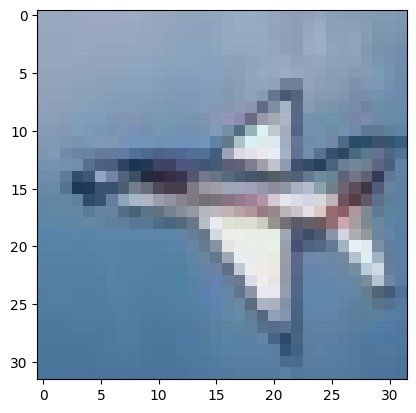

airplane


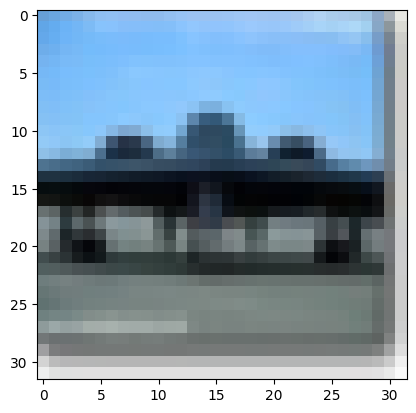

airplane


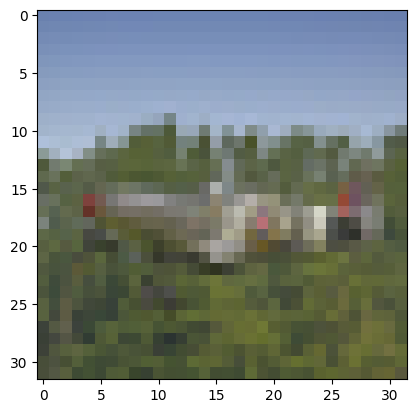

airplane


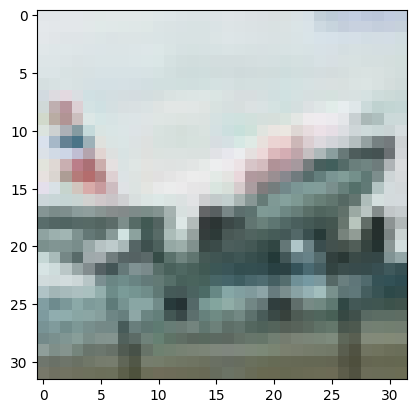

KeyboardInterrupt: ignored

In [ ]:
debug_target = cifer10_batches[0]

for label in range(n_labels):

    # 扱いやすいようにlistからnumpyに変換
    debug_labels = np.array(debug_target['labels'])
    # 特定のラベルのインデックスを抽出
    label_idxs = np.where(debug_labels==label)[0]
    # 特定のラベルのデータ, ラベルを抽出
    target_images = debug_target['data'][label_idxs]
    target_labels = debug_labels[label_idxs]

    debug_dataset = Cifar10Dataset(images=target_images,
                                labels=target_labels, is_train=True,
                                transforms=transforms)

    debug_loader = DataLoader(debug_dataset, batch_size=CONFIG["BATCH_SIZE"],
                            # num_workers=1,
                             shuffle=True,
                            #   pin_memory=True,
                            drop_last=False,
                            # worker_init_fn=lambda x: seed_everything(CONFIG["SEED"])
                            )

    images, labels = next(iter(debug_loader))

    print('label:', label)
    # show images
    for img, label in zip(images, labels):
        print(label_names[label])
        imshow(img)

    input('Press Enter to next label')

# 学習のための準備

## train/eval split

data_batch_{1,2,3,4}を訓練用、data_batch_5を評価用として用いることにします。

そのため、data_batch_{1,2,3,4}は結合して1つのdictにしましょう。

In [ ]:
train_dict = {'data': [], 'labels': []}
for i in range(4): # [0, 1, 2, 3]
  i_batch = cifer10_batches[i]
  train_dict['data'].append(i_batch['data'])
  train_dict['labels'].append(i_batch['labels'])

train_dict['data'] = np.concatenate(train_dict['data'], axis=0) # 結合
train_dict['labels'] = np.concatenate(train_dict['labels']) # 結合

In [ ]:
eval_dict = {'data': cifer10_batches[4]['data'], 'labels': cifer10_batches[4]['labels']}

## DataLoader

EDAの時と同様にして、Dataset、及びDataLoaderを作成します。

In [ ]:
train_dataset = Cifar10Dataset(images=train_dict['data'], labels=train_dict['labels'], is_train=True, transforms=transforms)
eval_dataset = Cifar10Dataset(images=eval_dict['data'], labels=eval_dict['labels'], is_train=True, transforms=transforms)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=CONFIG["BATCH_SIZE"],
                            #   num_workers=1,
                          shuffle=True,
                        #   pin_memory=True,
                          drop_last=False)
eval_loader = DataLoader(eval_dataset, batch_size=CONFIG["BATCH_SIZE"],
                            #   num_workers=1,
                         shuffle=False,
                        #  pin_memory=True,
                         drop_last=False)

## Model

Neural netのモデルを定義します。
- tutorial通りの非常にシンプルなモデルです。

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, in_channels, n_label):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_label)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = SimpleNet(in_channels=3, n_label=CONFIG["NUM_LABEL"])
model = model.to(CONFIG["DEVICE"])

## Loss

最小化する損失関数と呼ばれるものを定義します。
- この損失関数の最小化を勾配法で行うことで、学習をします。

RMSEでもなんでもいいですが、今回はチュートリアル通りクロスエントロピーを使います。
- クラスが正しく予測できていれば損失が少なくなる関数なら何でもいいです。
- RMSEもクロスエントロピーも、予測が正しいラベルに近いほど小さくなる値です。
 - 参考: https://qiita.com/kenta1984/items/59a9ef1788e6934fd962

In [ ]:
criterion = nn.CrossEntropyLoss()

クロスエントロピーの場合、入力は$[p_1, p_2, \dots, p_C]$のようになります。ここで、$C$はクラス数、$p_i$は$i$番目のクラスの予測確率です。
- 要するに今回なら
\begin{equation}
[\text{飛行機の予測確率}, \text{自動車の予測確率}, \dots, \text{トラックの予測確率}]
\end{equation}
という形になる、というだけです。
 - なぜこんな話をするかというと、RMSEの場合は単純に予測確率であるスカラー値$y_{\text{pred}}$を$\{0, 1, \dots, 9\}$に近づけるため、ただの1次元の入力になるためです。
 - 要するに、損失に応じて入力の形を変える必要がある、という話です。

## Optimizer

損失を最小化する手法を定義します。
- 勾配降下法などで、損失を反復的に最小化します。結果、予測が正しい方向へと寄っていきます。
- SGD（stochastic gradient descent）を色々いじって変形させた手法が用いられます。
 - AdamWが一番主流な気がするので、AdamWでやります。

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['LERANING_RATE'])

## Scheduler

Neural Netは非線形なので、特徴量から見た場合凹凸がある状態
- つまり、勾配法の初期値や手法によってどこに着地するか分からない
- schedulerで勾配に対して下る大きさを調節する

分かりやすいNotebook: https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling/notebook#5.-ExponentialLR

In [ ]:
# 参考：https://www.kaggle.com/code/awsaf49/uwmgi-unet-train-pytorch#%F0%9F%94%8D-Optimizer
def fetch_scheduler(optimizer):
    print('scheduler:', CONFIG['SCHEDULER'])
    if CONFIG['SCHEDULER'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG["T_max"],
                                                   eta_min=CONFIG["min_lr"])
    elif CONFIG['SCHEDULER'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG["T_0"],
                                                             eta_min=CONFIG["min_lr"])
    elif CONFIG['SCHEDULER'] == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=1e-7,)
    elif CONFIG['SCHEDULER'] == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CONFIG["SCHEDULER"] == 'COSINE_SCHEDULE_WITH_WARMUP':
        scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=CONFIG["SCHEDULER_CONFIG"]["NUM_WARMUP_STEPS"],
                                                    num_training_steps=len(train_loader)*CONFIG["EPOCH"])
    elif CONFIG['SCHEDULER'] == None:
        return None

    return scheduler

In [ ]:
scheduler = fetch_scheduler(optimizer)

scheduler: COSINE_SCHEDULE_WITH_WARMUP


## train/eval

参考： https://github.com/pytorch/examples/blob/main/imagenet/main.py

In [ ]:
def train(train_loader, model, criterion, optimizer, scheduler):
  loss_list = []
  score_list = []
  lrs = []

  model.train()
  for i, (data, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(data)

      loss = criterion(outputs, labels)
      loss_list.append(loss.item())

      loss.backward()

      optimizer.step()
      scheduler.step()

      lr = optimizer.param_groups[0]['lr']
      lrs.append(lr)

  loss = np.mean(loss_list)
  print(f'[Train]: loss: {loss} | lr: {lrs[-1]}')
  return loss


def validate(eval_loader, model, creterion, score_function):
  outputs_list = []
  labels_list = []

  model.eval()
  with torch.no_grad():
    for i, (data, labels) in tqdm(enumerate(eval_loader), total=len(eval_loader)):
      outputs = model(data)

      outputs_list.append(outputs)
      labels_list.append(labels)

    outputs = torch.cat(outputs_list, axis=0)
    labels = torch.cat(labels_list)

    loss = criterion(outputs, labels)
    loss = loss.item()

    outputs = outputs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    score = score_function(outputs, labels)

    print(f'[Eval]: loss: {loss} | score: {score}')
    return outputs, labels, loss, score

def acc_with_argmax(y_pred, y_true):
  y_pred_idx = np.argmax(y_pred, axis=1)
  return np.mean(y_pred_idx==y_true)

In [ ]:
score_function = acc_with_argmax

## Trainの前に、現状確認

モデルの初期状態（すなわち、Neural Netの重りがランダム）の予測はどうなるか見てみる。

In [ ]:
initial_result = validate(eval_loader, model, criterion, score_function)

  0%|          | 0/2500 [00:00<?, ?it/s]

[Eval]: loss: 3.5937983989715576 | score: 0.0989


In [ ]:
print('preds:', initial_result[0])
preds_idxs = np.argmax(initial_result[0], axis=1)
print('preds_idxs:', preds_idxs)
print('labels:', initial_result[1])
print('loss:', initial_result[2])
print('acc:', initial_result[3])

preds: [[-4.65106964e-01  1.62250531e+00  1.20548260e+00 ...  1.21505797e+00
  -2.40155244e+00 -5.60090899e-01]
 [-8.42583179e-02  6.93385363e-01  1.04475033e+00 ...  2.09049463e+00
  -1.97042120e+00 -6.64527297e-01]
 [-1.31451070e+00  3.83079022e-01 -3.96600008e-01 ...  7.47703850e-01
  -1.74822712e+00 -2.99113488e+00]
 ...
 [ 1.02017194e-01  1.02301884e+00 -5.70769966e-01 ...  1.85731339e+00
  -2.85705709e+00 -2.51344538e+00]
 [ 5.51603734e-01  6.98157430e-01  1.43969548e+00 ...  1.25412619e+00
  -2.23010421e+00 -1.12795949e+00]
 [-9.18683112e-02 -9.77899194e-01 -2.18113542e-01 ... -1.23910233e-03
  -2.19183588e+00 -1.03720784e+00]]
preds_idxs: [4 4 4 ... 4 4 6]
labels: [1 8 5 ... 9 1 1]
loss: 3.5937983989715576
acc: 0.0989


In [ ]:
print('unique of preds_idxs:', np.unique(preds_idxs))

unique of preds_idxs: [0 1 2 3 4 6 7]


- 愚直に乱数で予測すると、10クラスなので1/10=0.1で10%
- 今回の正解率（ACC）~0.1=10%
 - 初期状態の予測はランダムだと断定して良いようです。

念のため、可視化もして確認しておきます。

[pred]: deer | [label]: airplane


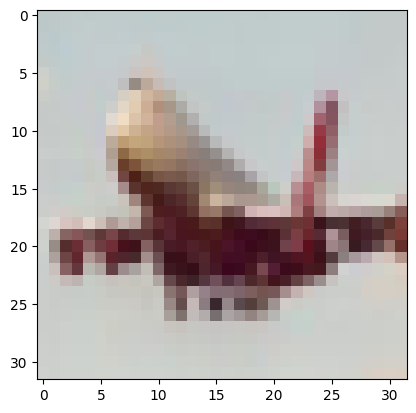

[pred]: deer | [label]: airplane


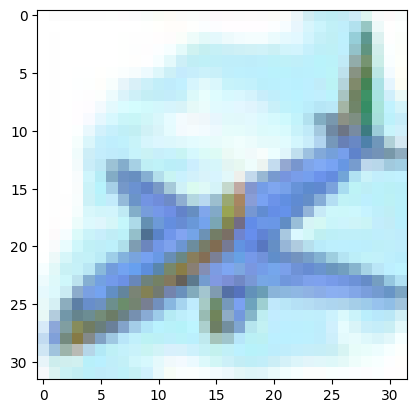

[pred]: deer | [label]: airplane


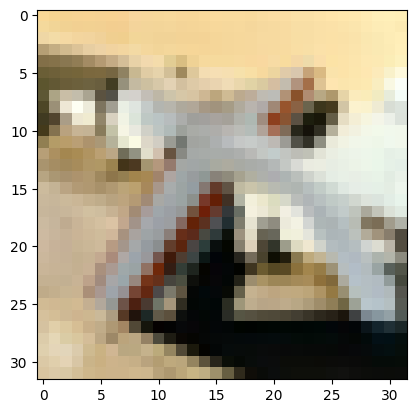

[pred]: deer | [label]: airplane


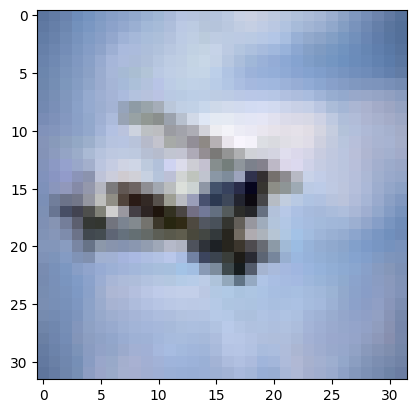

In [ ]:
images, labels = next(iter(debug_loader))

preds = model(images)
preds_idxs = torch.argmax(preds, axis=1)

for img, pred_idx, label in zip(images, preds_idxs, labels):
    print(f'[pred]: {label_names[pred_idx]} | [label]: {label_names[label]}')
    imshow(img)

想定通りの動作をしていそうです。
- 大体10枚に1枚で正解していればOKです。

# 学習・結果確認

学習を回します。
- Epoch数データを使いまわして学習します。

In [ ]:
for epoch in tqdm(range(CONFIG['EPOCH'])):

    print(f'------ EPOCH: {epoch} ------')

    train(train_loader, model, criterion, optimizer, scheduler)


    outputs, labels, loss, score = validate(eval_loader, model, criterion, score_function)

  0%|          | 0/5 [00:00<?, ?it/s]

------ EPOCH: 0 ------


  0%|          | 0/10000 [00:00<?, ?it/s]

[Train]: loss: 1.8039801217287779 | lr: 0.000904656202156525


  0%|          | 0/2500 [00:00<?, ?it/s]

[Eval]: loss: 1.6510406732559204 | score: 0.4024
------ EPOCH: 1 ------


  0%|          | 0/10000 [00:00<?, ?it/s]

[Train]: loss: 1.6044005908757448 | lr: 0.0006546877919903227


  0%|          | 0/2500 [00:00<?, ?it/s]

[Eval]: loss: 1.5633461475372314 | score: 0.451
------ EPOCH: 2 ------


  0%|          | 0/10000 [00:00<?, ?it/s]

[Train]: loss: 1.447289608129859 | lr: 0.00034561104488704916


  0%|          | 0/2500 [00:00<?, ?it/s]

[Eval]: loss: 1.4087597131729126 | score: 0.5007
------ EPOCH: 3 ------


  0%|          | 0/10000 [00:00<?, ?it/s]

[Train]: loss: 1.2961113693065942 | lr: 9.55284450319927e-05


  0%|          | 0/2500 [00:00<?, ?it/s]

[Eval]: loss: 1.365855097770691 | score: 0.5203
------ EPOCH: 4 ------


  0%|          | 0/10000 [00:00<?, ?it/s]

[Train]: loss: 1.1772455535836517 | lr: 0.0


  0%|          | 0/2500 [00:00<?, ?it/s]

[Eval]: loss: 1.3583186864852905 | score: 0.5267


- （再掲）愚直に乱数で予測すると、10クラスなので1/10=0.1で10%
 - 今回は評価用データの正解率（Accuracy）が約50%なのでモデルのfittingが出来ていそうです。

学習前と同じことを評価用データでやってみます。

In [ ]:
eval_loader_iter = iter(eval_loader) # イテレータのインスタンスを初期化
# images, labels = next(iter(eval_loader))

[pred]: automobile | [label]: automobile


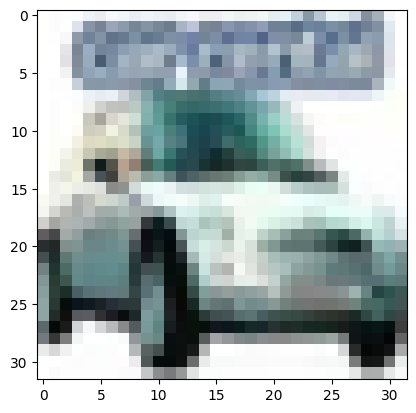

[pred]: airplane | [label]: ship


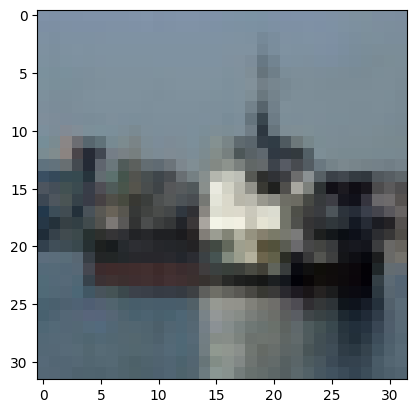

[pred]: cat | [label]: dog


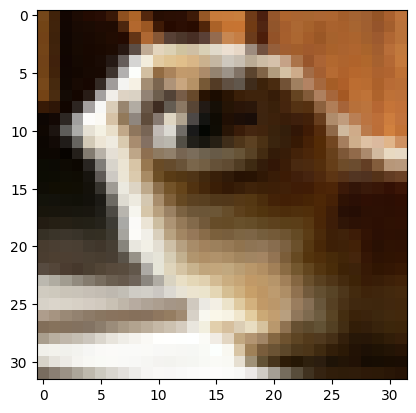

[pred]: automobile | [label]: automobile


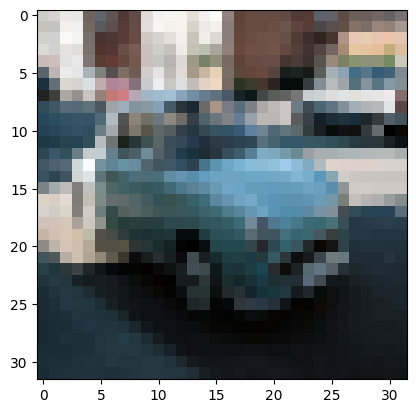

In [ ]:
images, labels = next(eval_loader_iter) # nextで次のインデックスへ

preds = model(images)
preds_idxs = torch.argmax(preds, axis=1)

for img, pred_idx, label in zip(images, preds_idxs, labels):
    print(f'[pred]: {label_names[pred_idx]} | [label]: {label_names[label]}')
    imshow(img)

2枚に1枚は正解していることが確認できたでしょうか。

## \[ハンズオン1] GPUに切り替える

GPUに切り替えて、モデルの速度を高速化しましょう。

ランタイム -> ランタイムのタイプを変更 -> ハードウェア アクセラレータを「None」から「GPU」にしましょう。

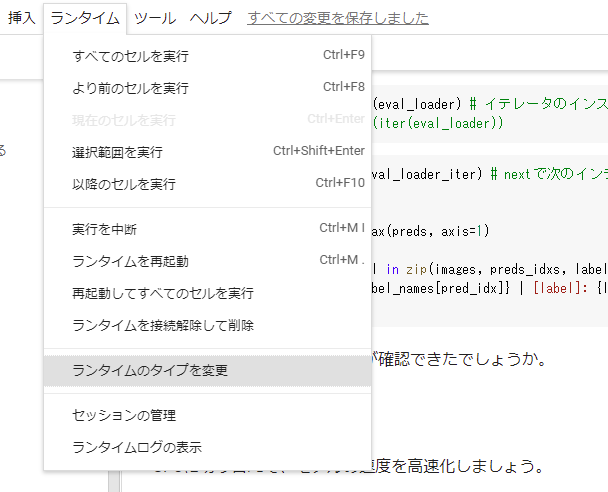

[CONFIG](#scrollTo=fHjVUW5HYXTt)のDEVICEがGPUと判定して、modelやtensorをGPUに載せるようになります。
- 厳密には、
```
to(CONFIG["DEVICE"])
```
でGPUに載せています。



ランタイム -> 「再起動してすべてのセルを実行」を押して、再度最初のセルから実行してみましょう。

## [ハンズオン2] 学習済みモデルをインポートする

https://www.kaggle.com/code/debarshichanda/efficientnetv2-mixup-leak-free/notebook

In [ ]:
class PretrainedModel(nn.Module):
    def __init__(self, model_name, in_channels, n_label, pretrained=True):
        super(PretrainedModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained,
                                       in_chans=in_channels, num_classes=n_label)
        # self.n_features = self.model.classifier.in_features
        # self.model.classifier = nn.Linear(self.n_features, n_label)

    def forward(self, x):
        output = self.model(x)
        return output

In [ ]:
# model_name = 'tf_efficientnetv2_s_in21k'
model_name = 'resnet18d'
n_channel = 3

model = PretrainedModel(model_name, n_channel, CONFIG['NUM_LABEL'])
model = model.to(CONFIG["DEVICE"])

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['LERANING_RATE'])

In [ ]:
scheduler = fetch_scheduler(optimizer)

scheduler: COSINE_SCHEDULE_WITH_WARMUP


In [ ]:
for epoch in tqdm(range(CONFIG['EPOCH'])):

    print(f'------ EPOCH: {epoch} ------')

    train(train_loader, model, criterion, optimizer, scheduler)


    outputs, labels, loss, score = validate(eval_loader, model, criterion, score_function)

メモ：

```
------ EPOCH: 4 ------

[Train]: loss: 0.7479159270916134 | lr: 0.0

[Eval]: loss: 2.646864175796509 | score: 0.6943
```

Epoch, lerning rateを工夫すればまだまだ上がる可能性がある。